In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
from math import log
from CIoTS import *
import json
from time import time
import random

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def plot_experiments(p, in_edges, dim, visualize, limit, results, delta=True, slope=False, title=''):
    limit = max([p, limit])

    for setting in results:
        if setting['in_edges'] != in_edges or setting['dim'] != dim or setting['p'] != p:
            continue

        if delta:
            plt.figure(figsize=(15, 15))
            ax1 = plt.subplot(2, 1, 1)
            ax2 = plt.subplot(2, 1, 2)
            ax1.set_xlim(0.5, limit+0.5)
            ax2.set_xlabel('p iteration')
            ax2.set_ylabel(visualize)
            ax2.set_title(f'{title}: true p = {p}, dimensions = {dim}, incoming edges = {in_edges} in last step')
            ax2.set_xlim(0.5, limit+0.5)
        else:
            plt.figure(figsize=(15, 8))
            ax1 = plt.subplot(1, 1, 1)
        
        ax1.set_xlabel('p iteration')
        ax1.set_ylabel(visualize)
        ax1.set_title(f'{title}: true p = {p}, dimensions = {dim}, incoming edges = {in_edges}')

        for experiment in setting['experiments']:
            true_graph = nx.from_dict_of_lists(experiment['true_graph'])
            iterations = [{'p_iter': i['p_iter'], 'bic': i['bic'], 'graph': nx.from_dict_of_lists(i['graph'], nx.DiGraph())} 
                          for i in experiment['iterations']]
            confusion, confusion_delta = evaluate_edge_deletion(true_graph, iterations, dim)

            if slope:
                x = confusion['p_iter'][:limit][1:]
                y = np.diff(confusion[visualize][:limit]) 
            else:  
                x = confusion['p_iter'][:limit]
                y = confusion[visualize][:limit]

            x_delta = confusion['p_iter'][:limit]
            y_delta = confusion_delta[visualize][:limit]

            ax1.plot(x, y, 'r-')
            if delta:    
                ax2.plot(x_delta, y_delta, 'r-')
                
        plt.show()
        break

In [4]:
dim = 3
in_edges = 2
p = 10
visualize = 'tn'
limit = 14

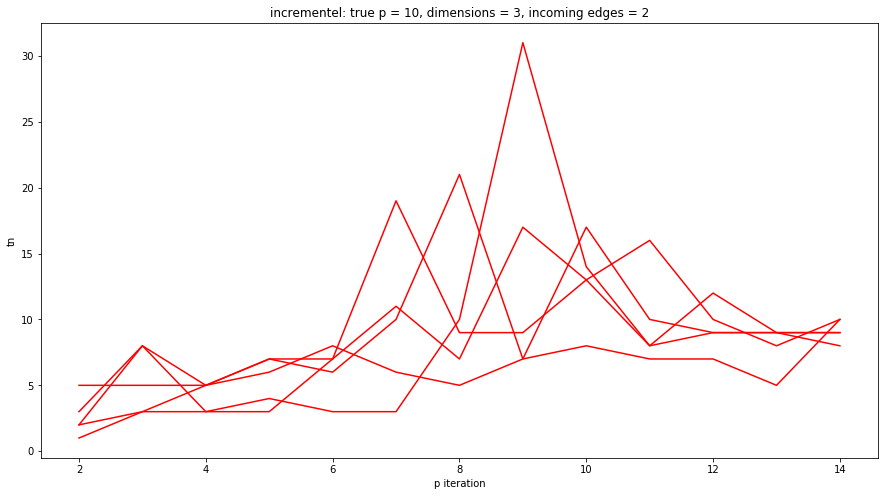

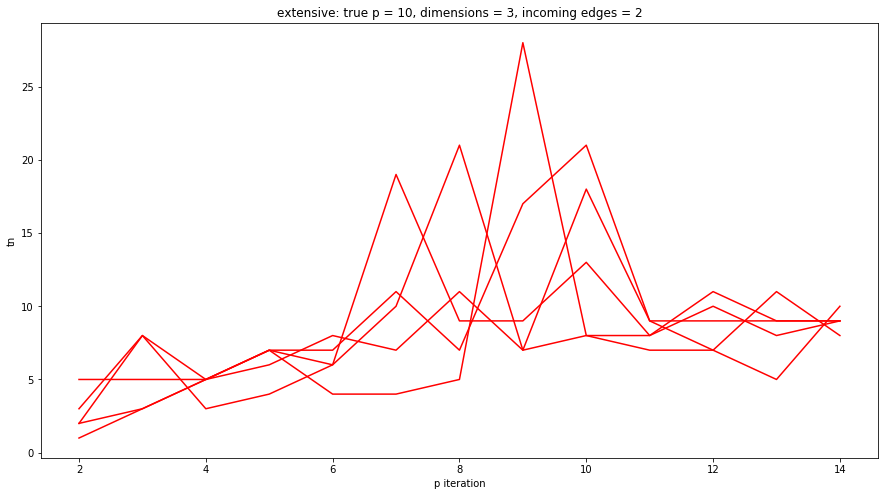

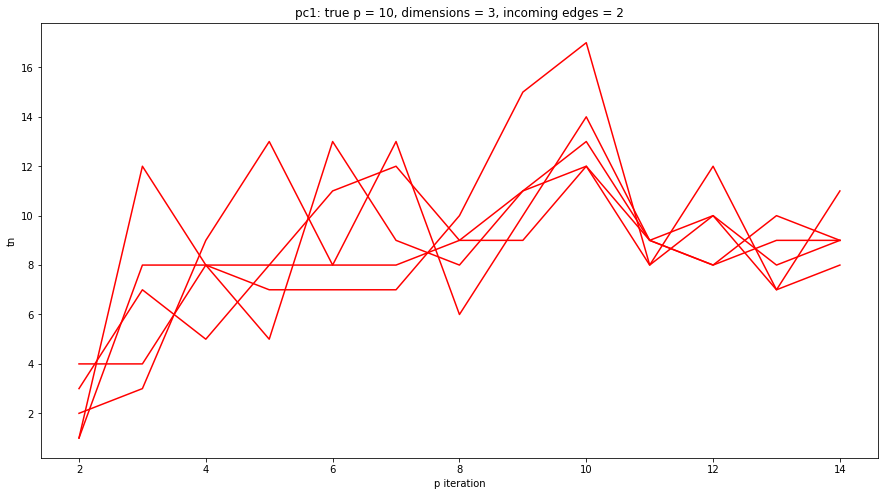

In [5]:
with open('results/edge_deletion.json', 'r') as f:
    results = json.load(f)
plot_experiments(p, in_edges, dim, visualize, limit, results, title='incrementel', slope=True, delta=False)
                 
with open('results/edge_deletion_extensive.json', 'r') as f:
    results = json.load(f)
plot_experiments(p, in_edges, dim, visualize, limit, results, title='extensive', slope=True, delta=False)

with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)
plot_experiments(p, in_edges, dim, visualize, limit, results, title='pc1', slope=True, delta=False)

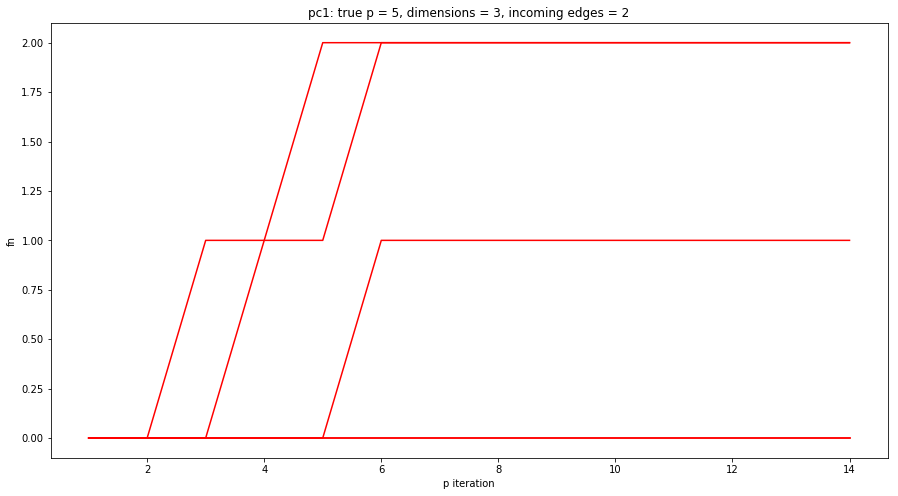

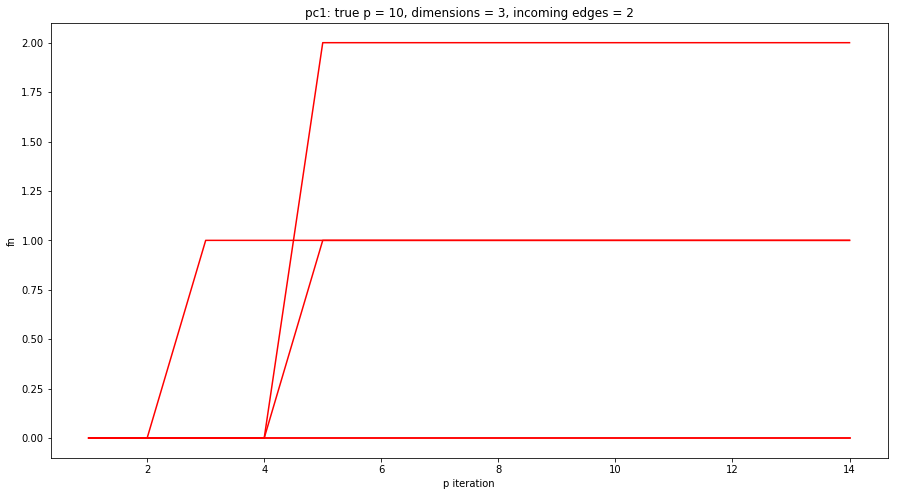

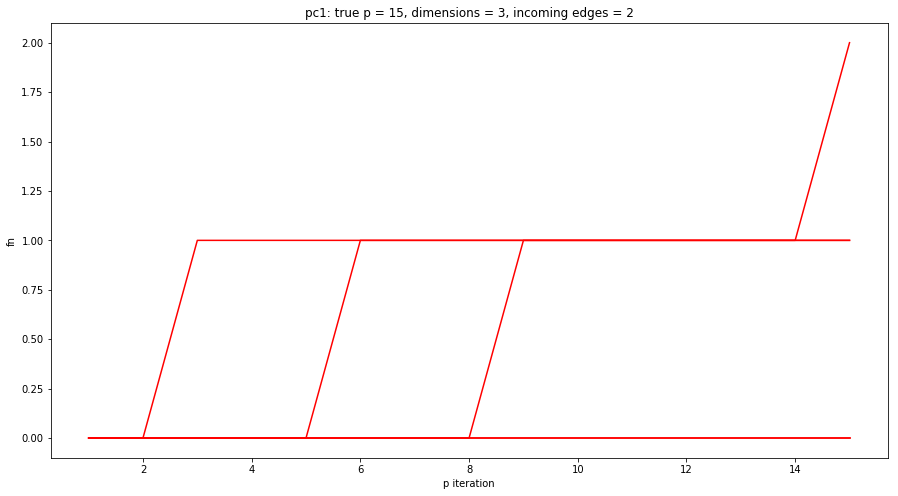

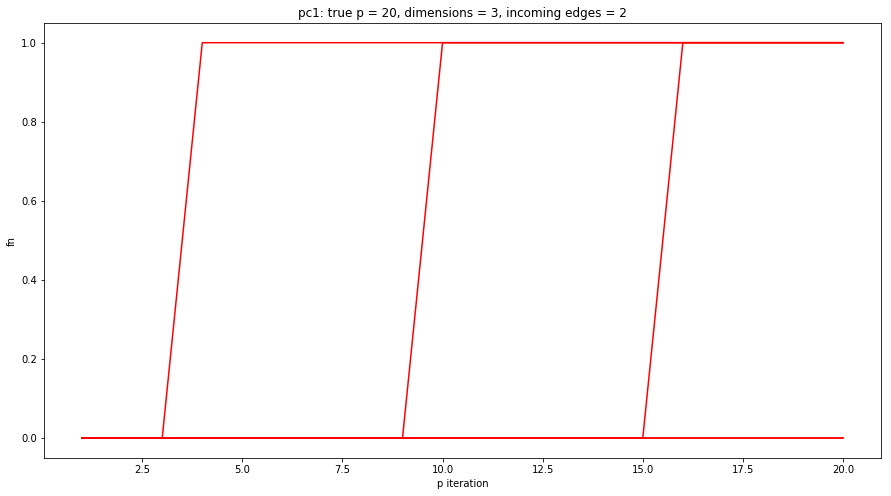

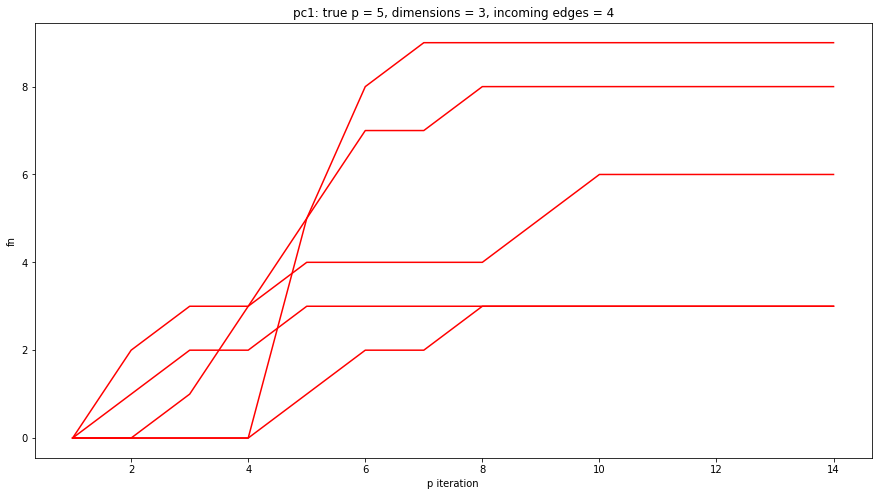

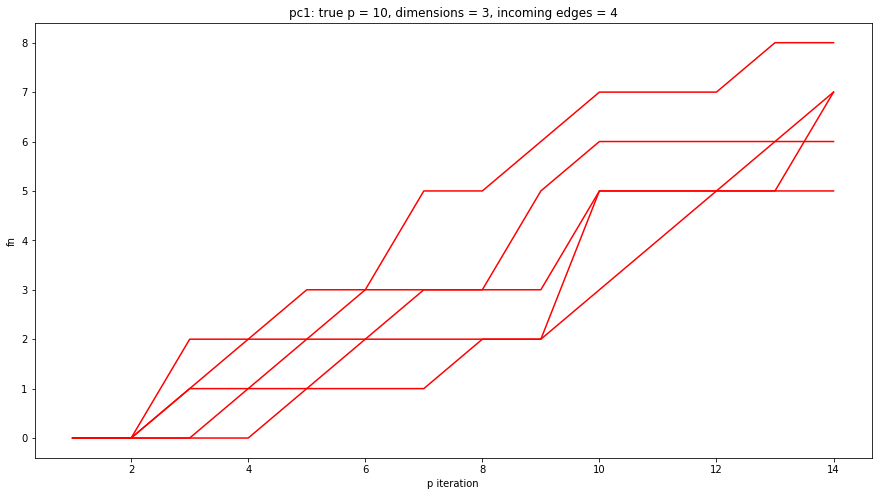

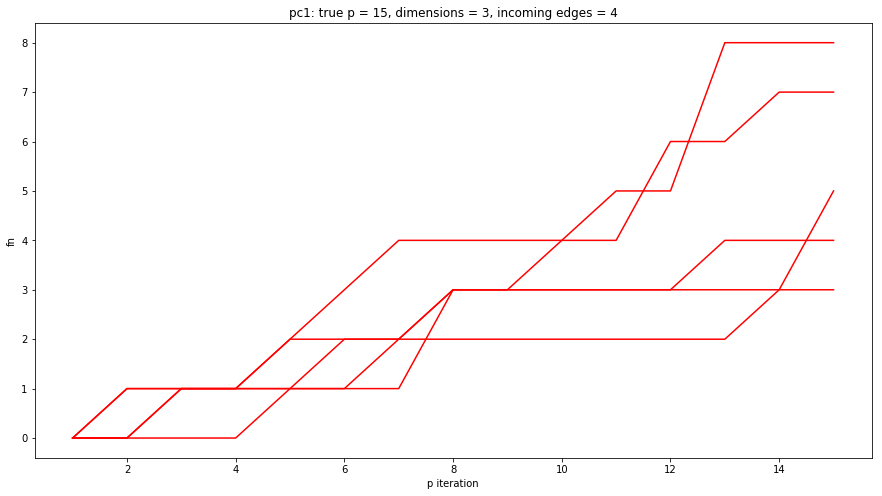

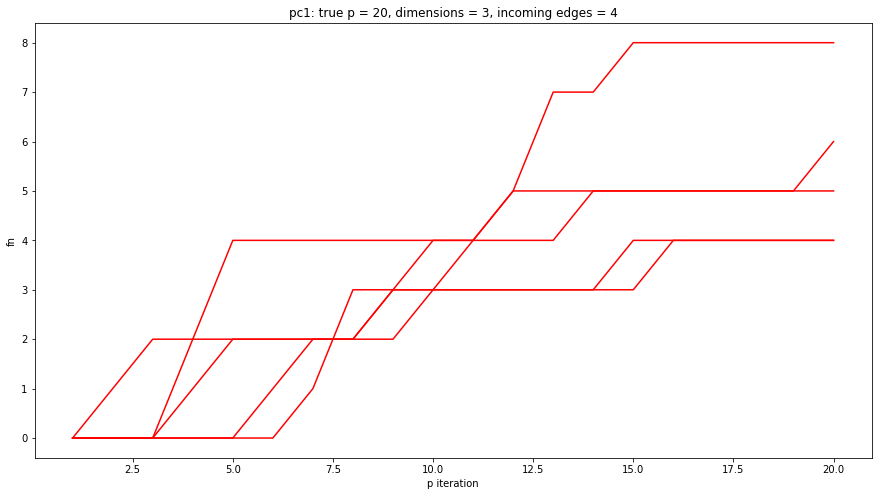

In [19]:
# with open('results/edge_deletion_extensive.json', 'r') as f:
#     results = json.load(f)
# plot_experiments(p, in_edges, dim, 'fn', limit, results, title='extensive', slope=False, delta=False)

settings = []
for setting in results:
    for experiment in setting['experiments']:
        settings.append((setting['in_edges'], setting['dim'], setting['p']))
settings = sorted(list(set(settings)))

with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)
    
    for setting in settings:
        plot_experiments(setting[2], setting[0], setting[1], 'fn', limit, results, title='pc1', slope=False, delta=False)

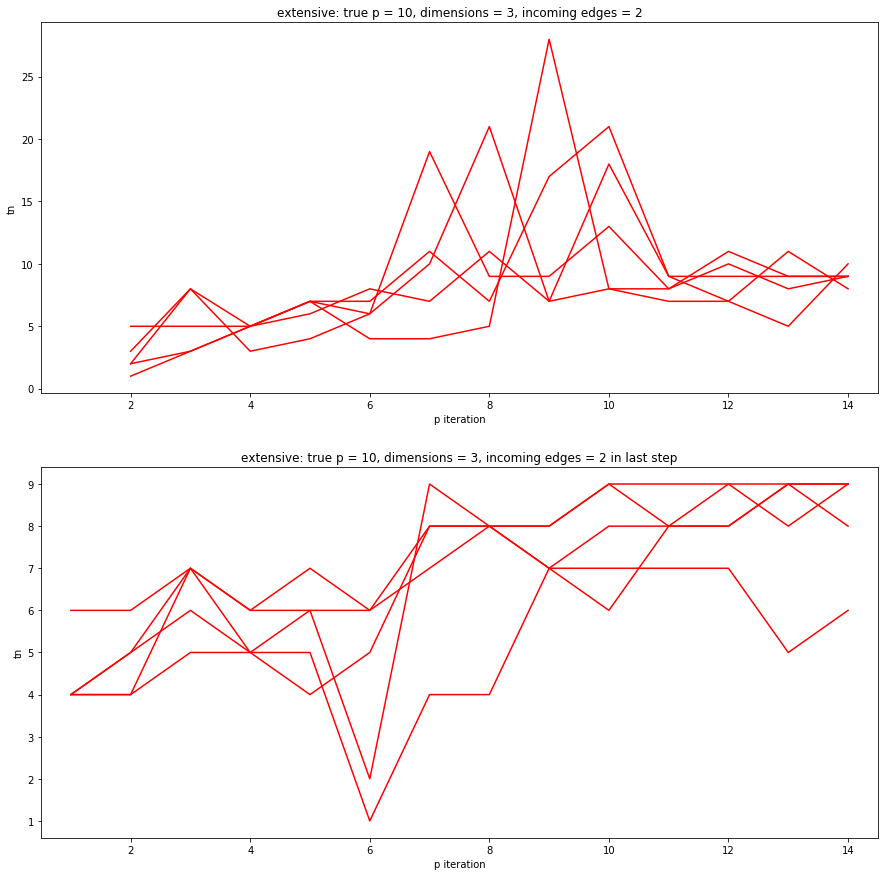

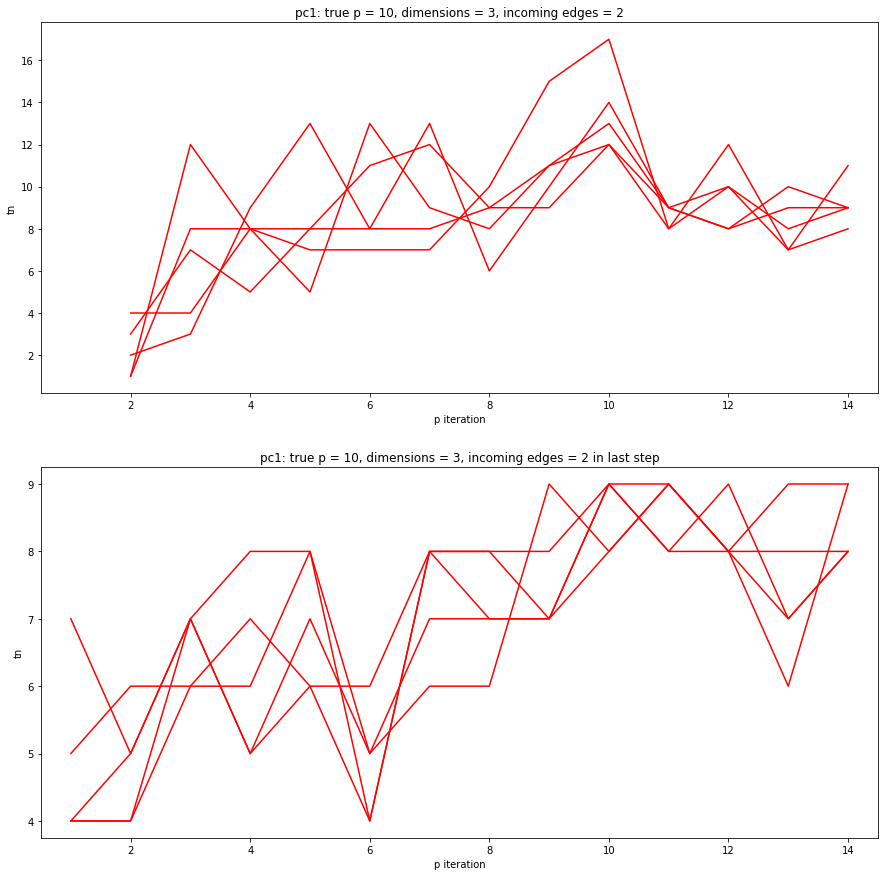

In [7]:
with open('results/edge_deletion_extensive.json', 'r') as f:
    results = json.load(f)
plot_experiments(p, in_edges, dim, 'tn', limit, results, title='extensive', slope=True, delta=True)

with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)
plot_experiments(p, in_edges, dim, 'tn', limit, results, title='pc1', slope=True, delta=True)

In [8]:
def plot_experiment_means(p, in_edges, dim, visualize, limit, results, delta=True, slope=False, title=''):
    limit = max([p, limit])

    for setting in results:
        if setting['in_edges'] != in_edges or setting['dim'] != dim or setting['p'] != p:
            continue
        
        if delta:
            fig = plt.figure(figsize=(15, 15))
            ax1 = fig.add_subplot(2, 1, 1)
            ax2 = fig.add_subplot(2, 1, 2)
            ax1.set_xlim(0.5, limit+0.5)
            ax2.set_xlabel('p iteration')
            ax2.set_ylabel(visualize)
            ax2.set_title(f'{title}: true p = {p}, dimensions = {dim}, incoming edges = {in_edges} in last step')
            ax2.set_xlim(0.5, limit+0.5)
        else:
            fig = plt.figure(figsize=(15, 8))
            ax1 = fig.add_subplot(1, 1, 1)
        
        ax1.set_xlabel('p iteration')
        ax1.set_ylabel(visualize)
        ax1.set_title(f'{title}: true p = {p}, dimensions = {dim}, incoming edges = {in_edges}')

        xs, ys = [], []
        x_deltas, y_deltas = [], []
        for experiment in setting['experiments']:
            true_graph = nx.from_dict_of_lists(experiment['true_graph'])
            iterations = [{'p_iter': i['p_iter'], 'bic': i['bic'], 'graph': nx.from_dict_of_lists(i['graph'], nx.DiGraph())} 
                          for i in experiment['iterations']]
            confusion, confusion_delta = evaluate_edge_deletion(true_graph, iterations, dim)

            if slope:
                x = confusion['p_iter'][:limit][1:]
                y = np.diff(confusion[visualize][:limit]) 
            else:  
                x = confusion['p_iter'][:limit]
                y = confusion[visualize][:limit]
                
            xs.append(x)
            ys.append(y)

            x_delta = confusion['p_iter'][:limit]
            y_delta = confusion_delta[visualize][:limit]
            
            x_deltas.append(x_delta)
            y_deltas.append(y_delta)
        
        xs, ys = np.array(xs), np.array(ys)
        x_deltas, y_deltas = np.array(x_deltas), np.array(y_deltas)
        ax1.errorbar(np.mean(xs, axis=0), np.mean(ys, axis=0), yerr=np.std(ys, axis=0), fmt='r-')
        if delta:    
            ax2.errorbar(np.mean(x_deltas, axis=0), np.mean(y_deltas, axis=0), yerr=np.std(y_deltas, axis=0), fmt='r-')
            
        return fig, xs, ys, x_deltas, y_deltas

Incremental: 
[ 2.6  5.4  4.2  5.4  6.2  9.8 10.4 14.2 13.   9.8  9.4  8.   9.2]
Extensive: 
[ 2.6  5.4  4.6  6.2  6.2 10.2 10.6 13.6 13.6  8.2  8.8  8.4  9. ]
PC1: 
[ 2.2  6.8  7.6  8.2  9.4  9.8  8.4 11.2 13.6  8.6  9.6  8.2  9.2]


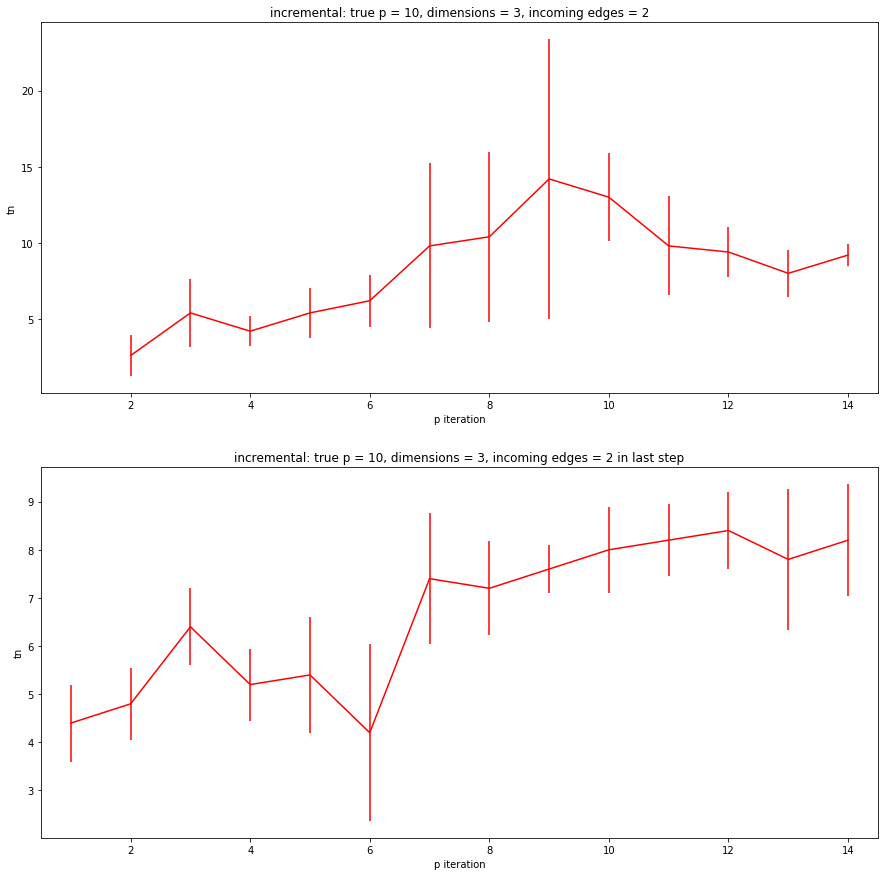

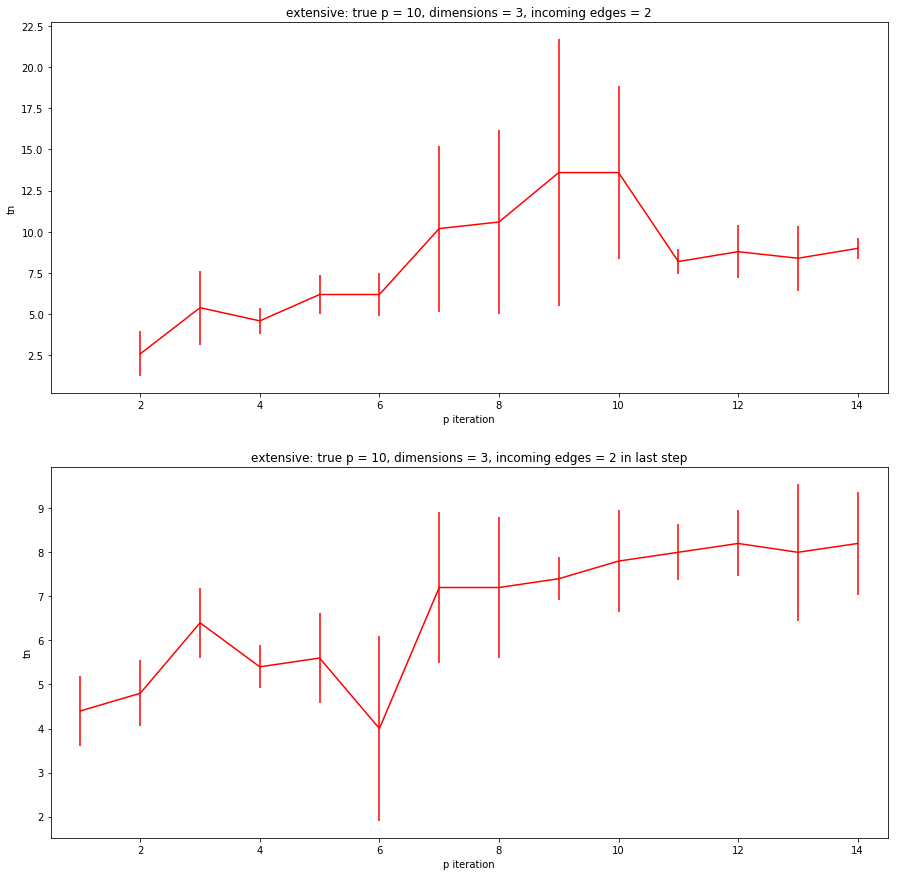

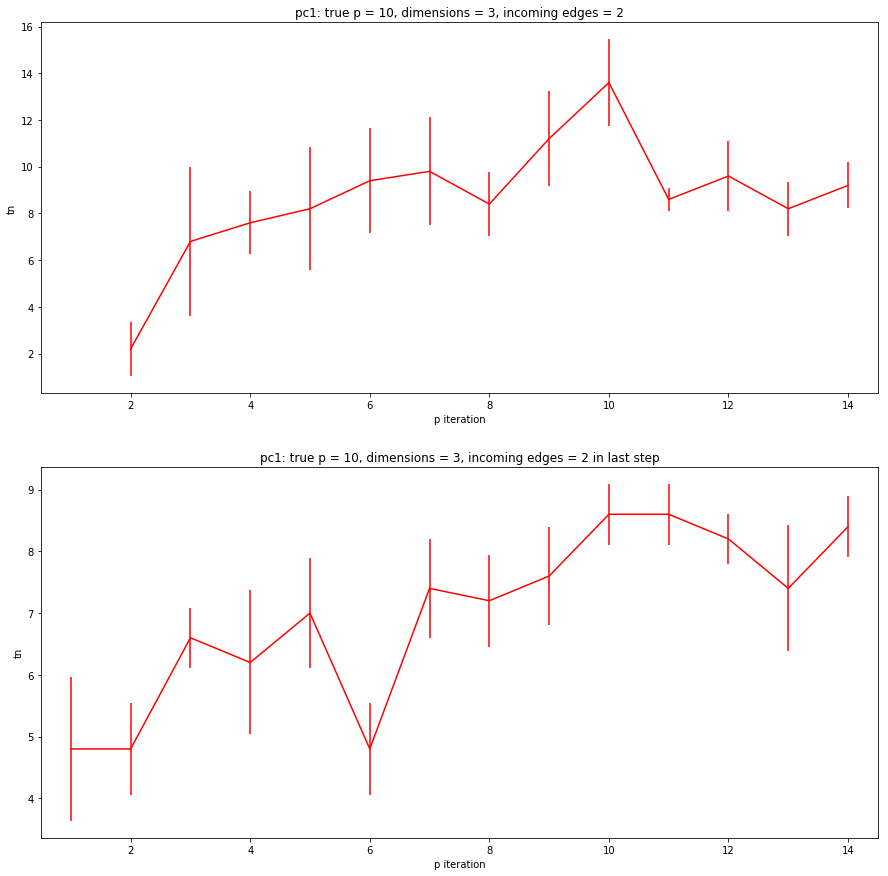

In [18]:
with open('results/edge_deletion.json', 'r') as f:
    results = json.load(f)
fig1, _, y1, _, y_delta1 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='incremental', slope=True, delta=True)
# plt.ylim([0, 25])

with open('results/edge_deletion_extensive.json', 'r') as f:
    results = json.load(f)
fig2, _, y2, _, y_delta2 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='extensive', slope=True, delta=True)
# plt.ylim([0, 25])

with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)
fig3, _, y3, _, y_delta3 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='pc1', slope=True, delta=True)
# plt.ylim([0, 25])

print('Incremental: \n{}'.format(np.mean(y1, axis=0)))
print('Extensive: \n{}'.format(np.mean(y2, axis=0)))
print('PC1: \n{}'.format(np.mean(y3, axis=0)))

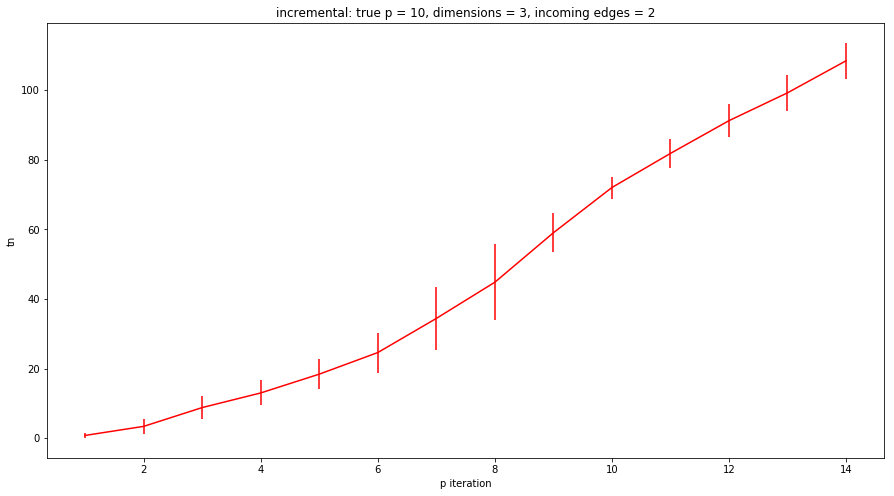

In [10]:
fig1

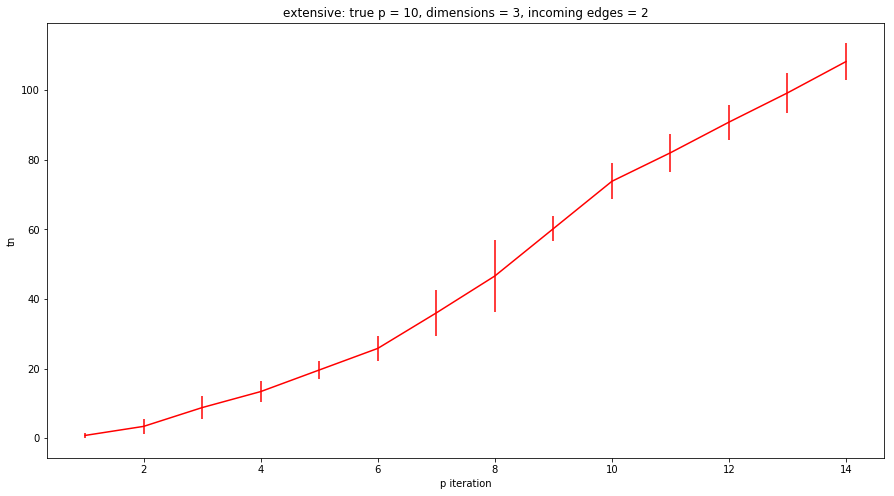

In [11]:
fig2

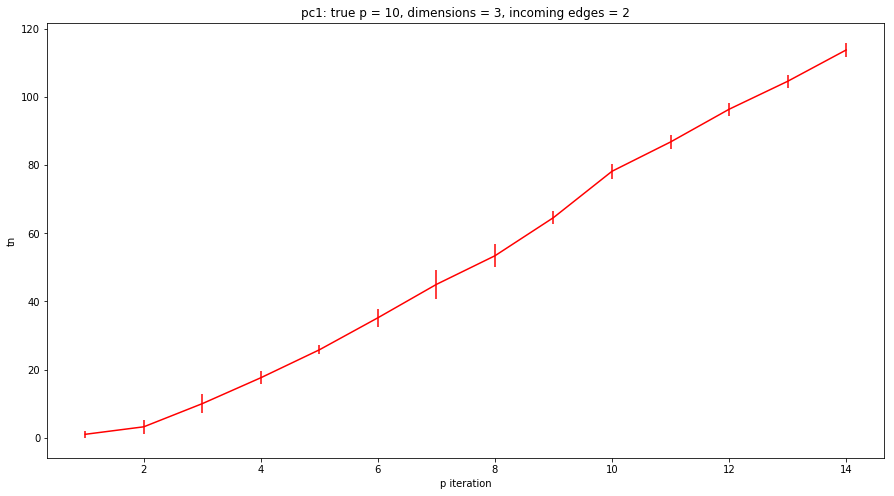

In [12]:
fig3

Incremental: 
[ 2.6  5.4  4.2  5.4  6.2  9.8 10.4 14.2 13.   9.8  9.4  8.   9.2]
Extensive: 
[ 2.6  5.4  4.6  6.2  6.2 10.2 10.6 13.6 13.6  8.2  8.8  8.4  9. ]
PC1: 
[ 2.2  6.8  7.6  8.2  9.4  9.8  8.4 11.2 13.6  8.6  9.6  8.2  9.2]


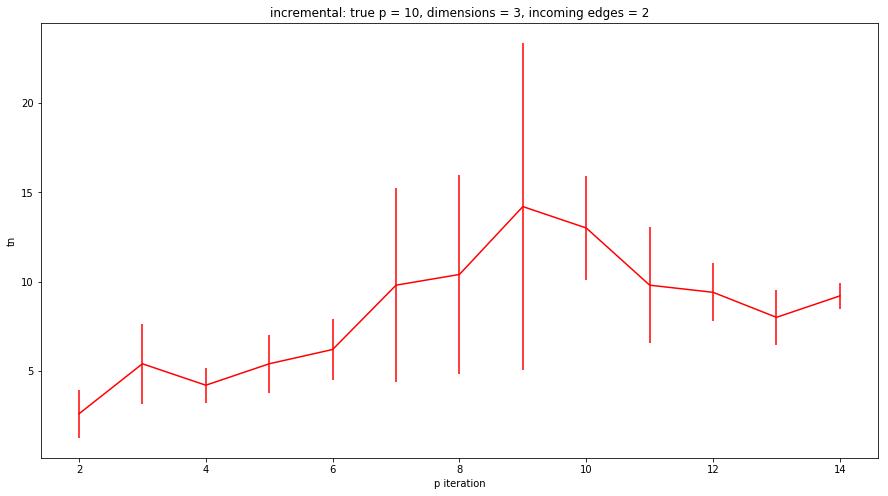

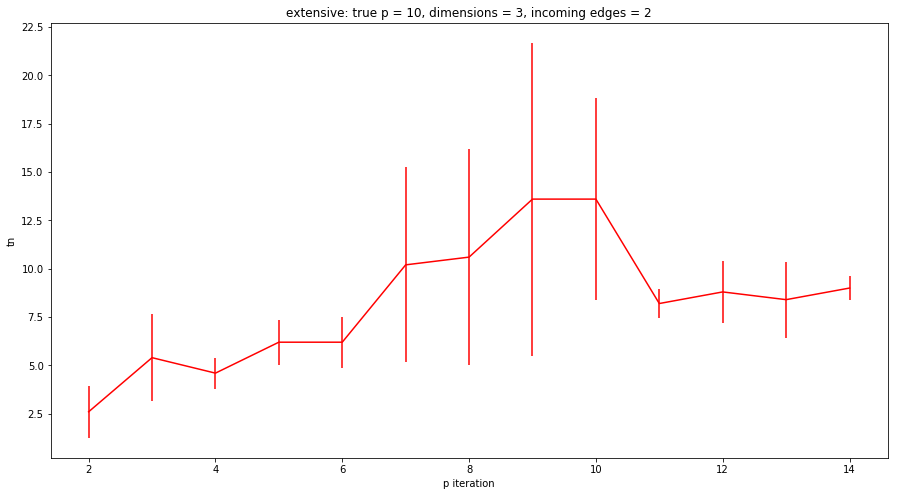

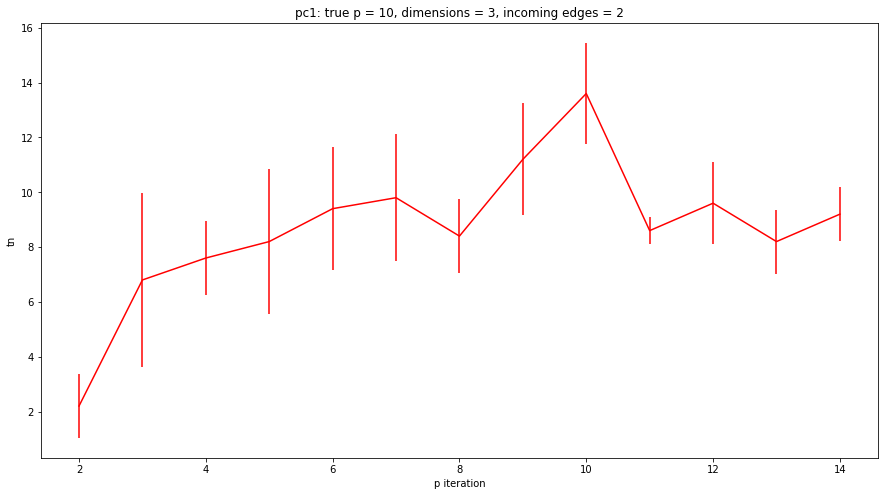

In [13]:
with open('results/edge_deletion.json', 'r') as f:
    results = json.load(f)
fig1, _, y1, _, y_delta1 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='incremental', slope=True, delta=False)
# plt.ylim([0, 25])

with open('results/edge_deletion_extensive.json', 'r') as f:
    results = json.load(f)
fig2, _, y2, _, y_delta2 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='extensive', slope=True, delta=False)
# plt.ylim([0, 25])

with open('results/edge_deletion_pc1.json', 'r') as f:
    results = json.load(f)
fig3, _, y3, _, y_delta3 = plot_experiment_means(
    p, in_edges, dim, visualize, limit, results, title='pc1', slope=True, delta=False)
# plt.ylim([0, 25])

print('Incremental: \n{}'.format(np.mean(y1, axis=0)))
print('Extensive: \n{}'.format(np.mean(y2, axis=0)))
print('PC1: \n{}'.format(np.mean(y3, axis=0)))

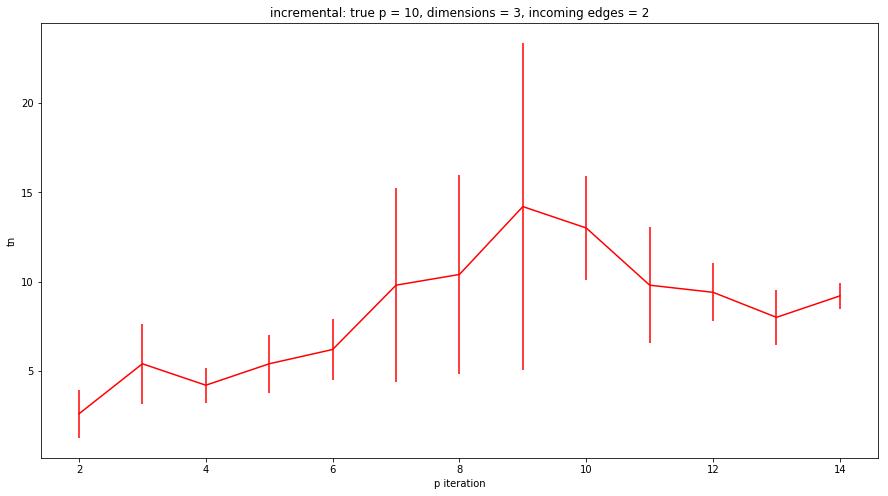

In [14]:
fig1

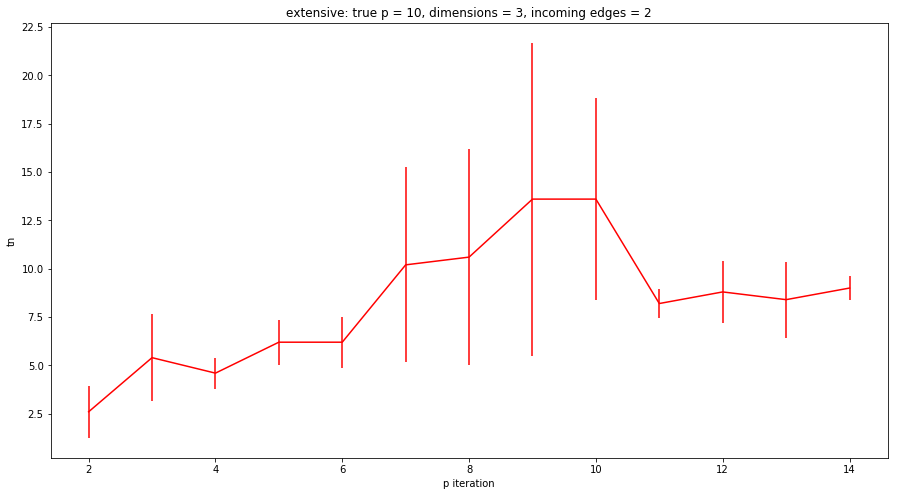

In [15]:
fig2

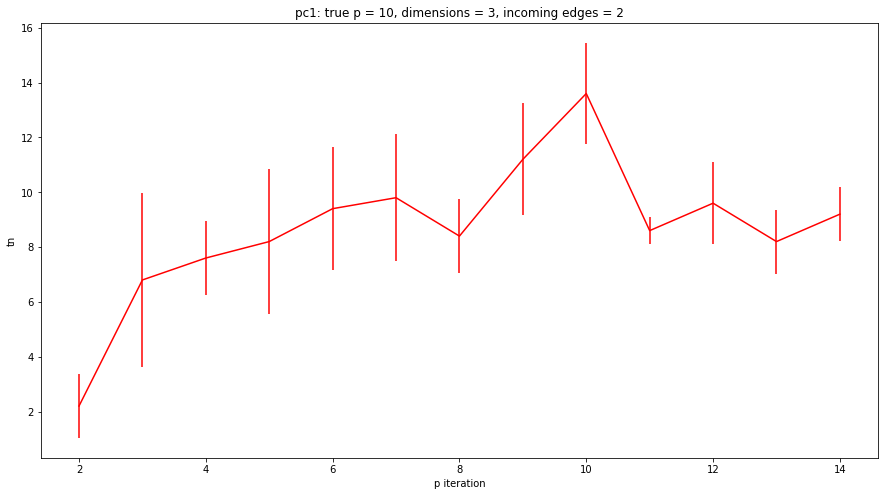

In [16]:
fig3